This notebook aims to assess the generalization accuracy of a generated suffix, assuming a data-split was used during training.

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from transformers import AutoTokenizer
import pandas as pd
import seaborn as sns
from types import SimpleNamespace
from datasets import Dataset
from os.path import join as oj
import pickle as pkl
import os
import dvu
dvu.set_style()
import analyze_utils
import sys
sys.path.append('..')
import data
from model_utils import prompt_classification

# Load the results + get generated suffixes

In [80]:
results_acc_dir = oj('/home/chansingh/interpretable-autoprompting/results/generalization_acc/accs_sweep')

In [81]:
accs = [
    pd.DataFrame.from_dict(pkl.load(open(oj(results_acc_dir, d), 'rb')))
    for d in os.listdir(results_acc_dir)
]
df = pd.concat(accs)
df['max_digit'] = df['max_digit'].fillna(10)
df = df.drop_duplicates()


In [82]:
math_one = ['square_one', 'exp_one', 'double_one', 'fibonacci_one']
math_two = ['add_two', 'multiply_two', 'divide_two', 'subtract_two',
                       'max_two', 'first_two']
math_three = ['add_three',
                         'multiply_three', 'max_three', 'first_three']

In [93]:

rows = {
    'Math tasks': df[(df.checkpoint == 'EleutherAI/gpt-j-6B') & (df.max_digit == 10) & (df.task_name.isin(math_one + math_two))],
    'Math tasks (2.7B model)': df[(df.checkpoint == 'EleutherAI/gpt-neo-2.7B') & (df.max_digit == 10) & (df.task_name.isin(math_one + math_two))],
    'Math tasks (2-digit)': df[(df.checkpoint == 'EleutherAI/gpt-j-6B') & (df.max_digit == 100) & (df.task_name.isin(math_two))],
    'Math tasks (2-digit, 2.7B model)': df[(df.checkpoint == 'EleutherAI/gpt-neo-2.7B') & (df.max_digit == 100) & (df.task_name.isin(math_two))],
    'Math tasks (3 numbers)': df[(df.checkpoint == 'EleutherAI/gpt-j-6B') & (df.max_digit == 10) & (df.task_name.isin(math_three))],
    'Math tasks (3 numbers, 2.7B model)': df[(df.checkpoint == 'EleutherAI/gpt-neo-2.7B') & (df.max_digit == 10) & (df.task_name.isin(math_three))],
}

In [94]:
order = ['manual', 'iprompt', 'autoprompt', '']
cols_rename = {
    'manual': 'Human-written',
    'iprompt': 'iPrompt',
    'autoprompt': 'AutoPrompt',
    '': 'No prompt',
}
vals = np.zeros((len(rows.keys()), len(order)))
idx = []
for i, k in enumerate(rows.keys()):    
    vals[i] = rows[k].groupby('prompt').mean()['acc'][order].values
    idx.append(k)

In [105]:
accs = pd.DataFrame(vals, index=idx, columns=order).rename(columns=cols_rename)
accs.insert(loc=3, column='Suffix', value=np.nan)
accs = accs.round(1)

In [107]:
print(accs.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  Human-written &  iPrompt &  AutoPrompt &  Suffix &  No prompt \\
\midrule
Math tasks                         &           54.0 &     51.5 &        41.6 &     NaN &       16.3 \\
Math tasks (2.7B model)            &           22.3 &     23.5 &        21.5 &     NaN &       18.3 \\
Math tasks (2-digit)               &           42.1 &     32.4 &        36.9 &     NaN &       16.4 \\
Math tasks (2-digit, 2.7B model)   &           27.2 &     15.0 &        18.0 &     NaN &       11.6 \\
Math tasks (3 numbers)             &           45.7 &     35.3 &        51.0 &     NaN &       26.7 \\
Math tasks (3 numbers, 2.7B model) &           24.5 &     13.6 &        18.1 &     NaN &       13.6 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1976112/4258992417.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(accs.to_latex())


# Debugging

,checkpoint,prompt,task_name,n_shots,max_digit,prompt_actual,acc
0,EleutherAI/gpt-j-6B,autoprompt,add_two,1,100.0,addedthe +the use worked,58.9
1,EleutherAI/gpt-j-6B,iprompt,add_two,1,100.0,Write a function int add(,42.3
4,EleutherAI/gpt-j-6B,autoprompt,multiply_two,1,100.0,multiplythethe �the Multiple,17.7
5,EleutherAI/gpt-j-6B,iprompt,multiply_two,1,100.0,When you multiply two (,11.3
8,EleutherAI/gpt-j-6B,autoprompt,divide_two,1,100.0,Kaplan MAG comprisingthe quarterly disproport...,0.0
9,EleutherAI/gpt-j-6B,iprompt,divide_two,1,100.0,"n / N,where we",5.3
12,EleutherAI/gpt-j-6B,autoprompt,subtract_two,1,100.0,opposably exactly subtractFor YEAR,41.3
13,EleutherAI/gpt-j-6B,iprompt,subtract_two,1,100.0,If n > m then subtract,59.2
16,EleutherAI/gpt-j-6B,autoprompt,max_two,1,100.0,NumberthetheJusticeJaDefault,49.2
17,EleutherAI/gpt-j-6B,iprompt,max_two,1,100.0,Which number has a bigger value,54.9


<AxesSubplot:xlabel='task_name', ylabel='acc'>

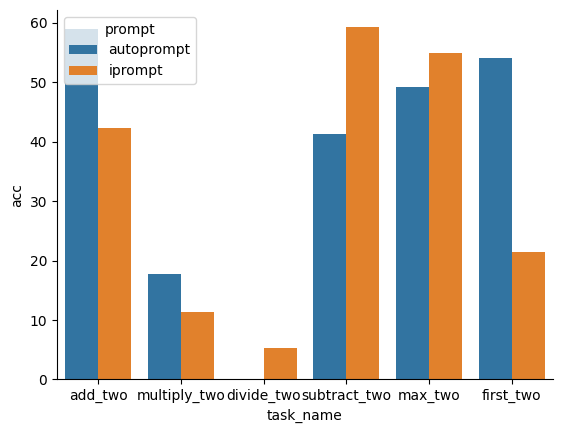

In [102]:
row = rows['Math tasks (2-digit)']
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    row = row[row.prompt.isin(['autoprompt', 'iprompt'])]
    display(row.groupby('prompt').head(1000).round(1))
sns.barplot(data=row, x='task_name', y='acc', hue='prompt')

,checkpoint,prompt,task_name,n_shots,max_digit,prompt_actual,acc
0,EleutherAI/gpt-j-6B,autoprompt,add_three,1,10.0,addedthe +the use worked,25.1
1,EleutherAI/gpt-j-6B,iprompt,add_three,1,10.0,Write a function int add(,21.7
4,EleutherAI/gpt-j-6B,autoprompt,multiply_three,1,10.0,multiplythethe �the Multiple,21.5
5,EleutherAI/gpt-j-6B,iprompt,multiply_three,1,10.0,When you multiply two (,26.7
8,EleutherAI/gpt-j-6B,autoprompt,max_three,1,10.0,NumberthetheJusticeJaDefault,57.5
9,EleutherAI/gpt-j-6B,iprompt,max_three,1,10.0,Which number has a bigger value,50.7
12,EleutherAI/gpt-j-6B,autoprompt,first_three,1,10.0,greater name sorting indiscrim to numbers,100.0
13,EleutherAI/gpt-j-6B,iprompt,first_three,1,10.0,The first digit of both values,42.3


<AxesSubplot:xlabel='task_name', ylabel='acc'>

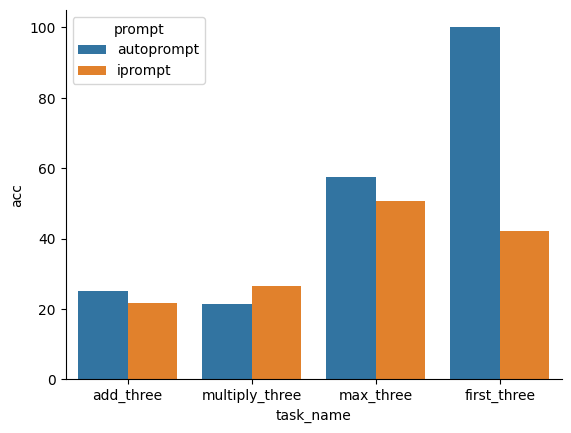

In [103]:
row = rows['Math tasks (3 numbers)']
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    row = row[row.prompt.isin(['autoprompt', 'iprompt'])]
    display(row.groupby('prompt').head(1000).round(1))
sns.barplot(data=row, x='task_name', y='acc', hue='prompt')